In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

import torch
import torch.optim as optim
import muon as mu
import yaml
import os
import sys
from utils import *
sys.path.append('../Autoencoder')
from autoencoder.data.scrnaseq_loader import RNAseqLoader
from autoencoder.models.base.encoder_model import EncoderModel

import argparse
sys.path.append('..')
from mm_diffusion.multimodal_script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict
)
from mm_diffusion import dist_util
import mygene

import shutup
shutup.please()

/home/lep/miniconda3/envs/scmuldiff/lib/python3.8/site-packages/lightning_lite/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_lite')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/lep/miniconda3/envs/scmuldiff/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/lep/miniconda3/envs/scmuldiff/lib/python3.8/site-packages/pytorch_lightning/__init__.py:45: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is pref

In [11]:
# ordered type list
type_list = np.array(['CD14+ Mono', 'ID2-hi myeloid prog', 'CD16+ Mono', 'cDC2',
                       'pDC', 'HSC', 'G/M prog','Lymph prog','MK/E prog', 'Naive CD20+ B',
                       'B1 B', 'Transitional B', 'Plasma cell','CD4+ T naive','CD4+ T activated',
         'CD8+ T', 'CD8+ T naive','NK', 'ILC', 'Proerythroblast','Erythroblast','Normoblast', ])

# calculate attention map

load autoencoder and diffusion model

In [2]:
encoder_config = "encoder_multimodal"
dataset_path = '/stor/lep/diffusion/multiome/openproblem_filtered.h5mu'
covariate_keys = "cell_type" 
num_class = 22
ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal/checkpoints/last.ckpt"

In [3]:
mdata = mu.read_h5mu(dataset_path)
real_cell = mdata['rna'][::5].X.toarray()
real_cell2 = mdata['atac'][::5].X.toarray()
# real_cell = mdata['rna'][mdata['rna'].obs['cell_type']=='CD4+ T activated'].X.toarray()[::7]
# real_cell2 = mdata['atac'][mdata['atac'].obs['cell_type']=='CD4+ T activated'].X.toarray()[::7]
real_cell.shape

(13850, 13431)

In [4]:
# load autoencoder
with open(f'{os.getcwd()}/../../Autoencoder/configs/encoder/{encoder_config}.yaml', 'r') as file:
    yaml_content = file.read()
autoencoder_args = yaml.safe_load(yaml_content)
autoencoder_args['encoder_kwargs']['rna']['norm_type']='batchnorm'
autoencoder_args['encoder_kwargs']['atac']['norm_type']='batchnorm'

# Initialize encoder
encoder_model = EncoderModel(in_dim={'atac': real_cell2.shape[1], 'rna': real_cell.shape[1]},
                                    n_cat=mdata['rna'].obs[covariate_keys].unique().shape[0],
                                    conditioning_covariate=covariate_keys, 
                                    encoder_type='learnt_autoencoder',
                                    **autoencoder_args)

# Load weights 
encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])


<All keys matched successfully>

In [8]:
# set diffusion backbone config
defaults = dict(
    clip_denoised=True,
    batch_size=16,
    sample_fn="ddim",
    multimodal_model_path="/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/checkpoints_cross/open_lr1e4_w512_scale124_drop0_80w_rescale10_3crossatt64_condi/model800000.pt",
    output_dir="test",
    classifier_scale=0,
    devices='0',
    is_strict=True,
    all_save_num= 1024,
    seed=42,
    load_noise="",
    data_dir=dataset_path,
    condition='cell_type',
)
defaults.update(model_and_diffusion_defaults())
parser = argparse.ArgumentParser()
defaults['video_size'] = '1,100'
defaults['audio_size'] = '1,100'
defaults['num_channels'] = 128
defaults['num_res_blocks'] = 1
defaults['resblock_updown'] = True
defaults['num_class'] = 22
defaults['class_cond'] = True
add_dict_to_argparser(parser, defaults)

In [9]:
# load diffusion backbone
args = parser.parse_known_args()[0]
args.video_size = [int(i) for i in args.video_size.split(',')]
args.audio_size = [int(i) for i in args.audio_size.split(',')]

dist_util.setup_dist(args.devices)

print("creating model and diffusion...")
multimodal_model, multimodal_diffusion = create_model_and_diffusion(
        **args_to_dict(args, [key for key in model_and_diffusion_defaults().keys()])
)
multimodal_model.load_state_dict_(
        dist_util.load_state_dict(args.multimodal_model_path, map_location="cpu"), is_strict=args.is_strict
)
multimodal_model.to(dist_util.dev())
optimizer2 = optim.Adam(multimodal_model.parameters(), lr=0.001)

# mdata = mu.read_h5mu(args.data_dir)
from sklearn.preprocessing import LabelEncoder
labels = mdata['rna'].obs[args.condition].values
label_encoder = LabelEncoder()
label_encoder.fit(labels)
classes_all = label_encoder.transform(labels)

rna = mdata['rna']#[mdata['rna'].obs['cell_type']=='Erythroblast']
atac = mdata['atac']#[mdata['atac'].obs['cell_type']=='Erythroblast']

0
creating model and diffusion...


In [13]:
# calculate attention maps in each layers
time_step = 1
down_sample = 2
model_kwargs = {}
batch = {}

x1 = torch.tensor(rna[::down_sample].X.toarray(),requires_grad=True)
x2 = torch.tensor(atac[::down_sample].X.toarray(),requires_grad=True)

batch["X_norm"] = {'rna':x1,'atac':x2}
z = encoder_model.encode(batch)
video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())

noise ={"video":torch.randn_like(video_start),\
    "audio":torch.randn_like(audio_start)}

#0 means t_th step, 1 means the audio gives groundtruth, 2 means the video gives the groundtruth
# condition_index = x_start["condition"]  
t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])#.detach()
audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])#.detach()

att_layer1 = []
att_layer1_atac = []
att_layer2 = []
att_layer2_atac = []
att_layer3 = []
att_layer3_atac = []
for celltype in type_list:
    index = (rna[::down_sample].obs['cell_type'] == celltype)
    # sample_id = np.random.choice(np.arange(0, index.sum()), size=22, replace=False)
    video_t_i = video_t[index][:10000]#[sample_id]
    audio_t_i = audio_t[index][:10000]#[sample_id]
    t_i = t[index][:10000]#[sample_id]
    labels = model_kwargs["label"][index][:10000]#[sample_id]

    noise_pred_video, noise_pred_video, att_maps = multimodal_model(video_t_i,audio_t_i,t_i,labels,return_attvec=True)
    att_layer1.append(att_maps[3])
    att_layer2.append(att_maps[7])
    att_layer3.append(att_maps[11])
    att_layer1_atac.append(att_maps[2])
    att_layer2_atac.append(att_maps[6])
    att_layer3_atac.append(att_maps[10])

find the key columns in different cell type

Text(0.5, 0, 'gene')

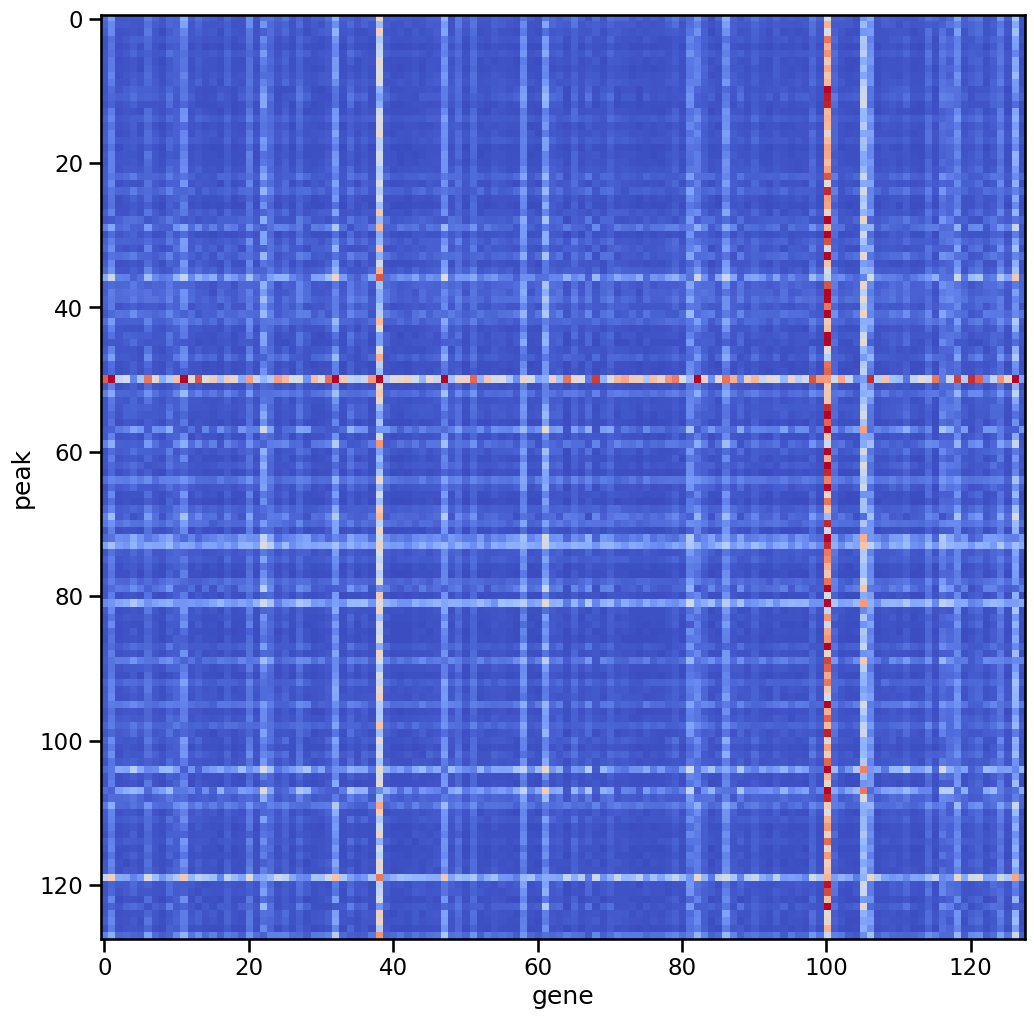

In [ ]:
# fine the key elements in gene and peak. 14 is the target cell type index (CD4+ T activated here)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(12,12))
plt.imshow(att_layer2[14].mean(0).cpu().detach().numpy()+att_layer2_atac[14].mean(0).cpu().detach().numpy().T,vmax=0.2,cmap='coolwarm')
plt.ylabel('peak')
plt.xlabel('gene')

In [19]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
cross_map = att_layer2[14].mean(0).cpu().detach().numpy()+att_layer2_atac[14].mean(0).cpu().detach().numpy().T
flattened_indices = np.argsort(cross_map, axis=None)[-10:]
positions = np.unravel_index(flattened_indices, cross_map.shape)
max_values = cross_map[positions]
print("The position (x,y) of the top10 elements:")
print('x(peak):', positions[0])
print('y(gene):', positions[1])
print("Top 10 values:", max_values)

The position (x,y) of the top10 elements:
x(peak): [ 50  50  81  79  50  45  28  50  57 107]
y(gene): [ 11  47 100 100  38 100 100 126 100 100]
Top 10 values: [0.22636247 0.2294471  0.23520574 0.23761243 0.23839217 0.2453197
 0.24915317 0.25201848 0.25299454 0.2953034 ]


Text(0.5, 1.0, 'what gene element to focus')

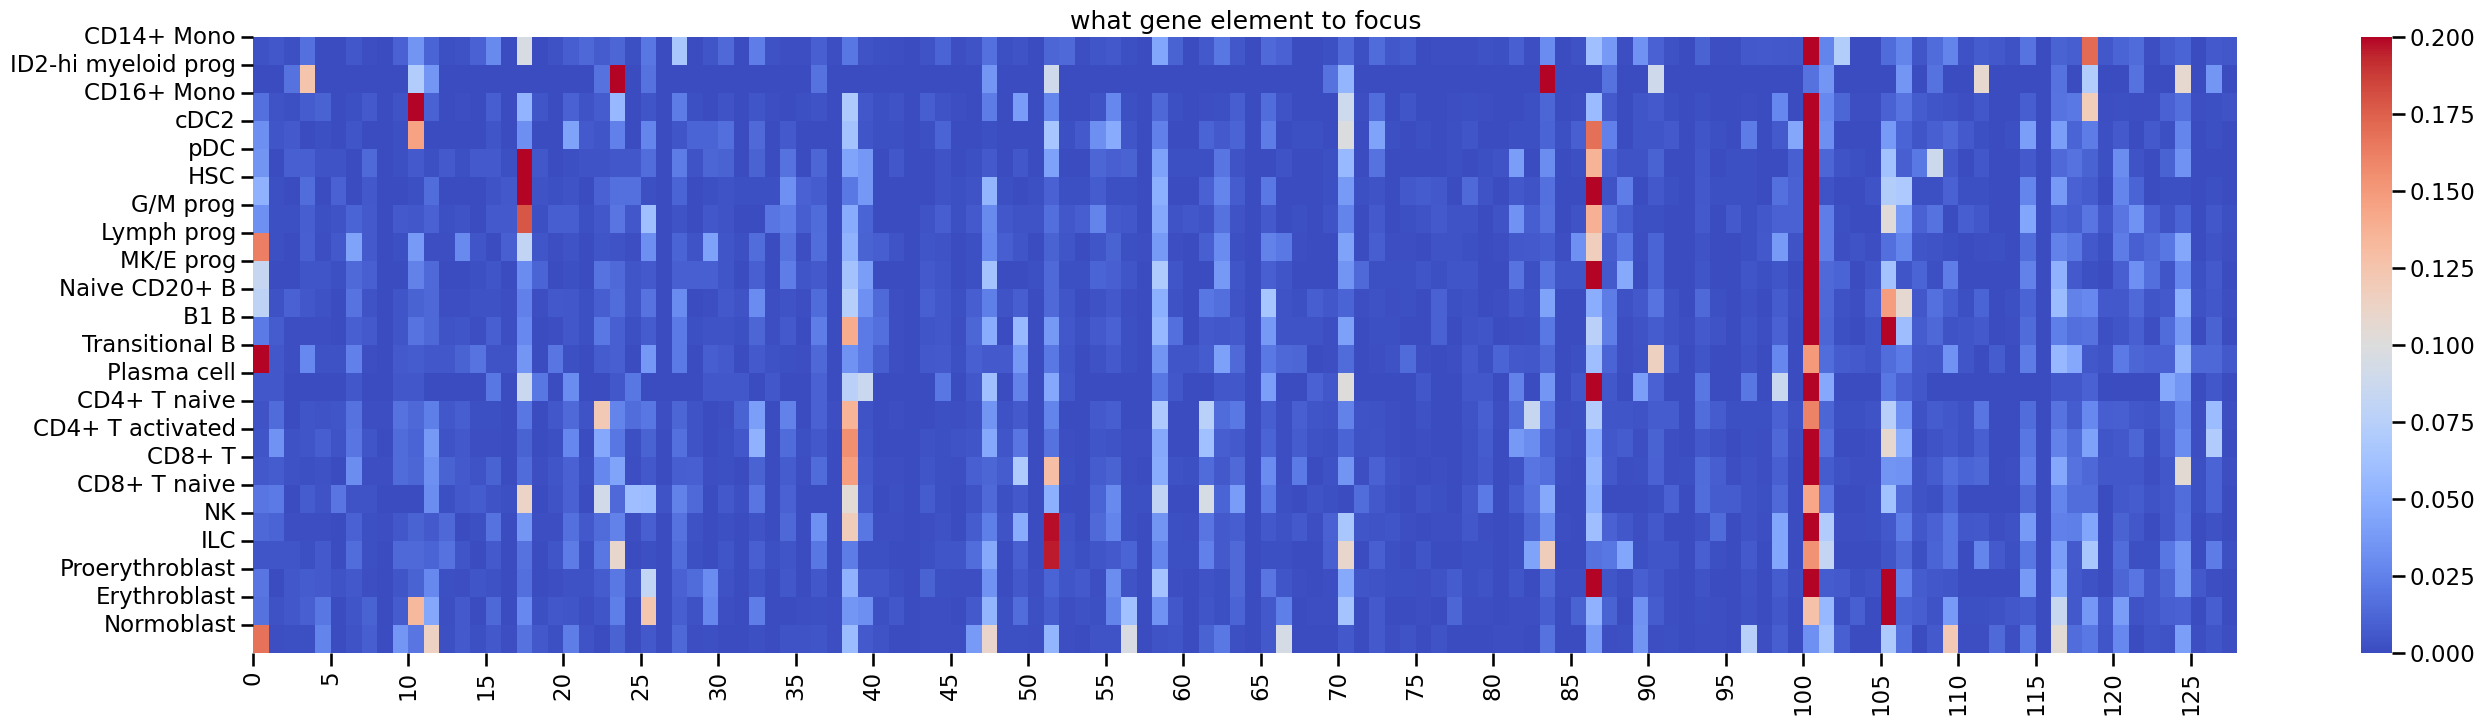

In [21]:
# which gene elements are most concerned by peak
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
key_col = np.zeros((len(att_layer2),att_layer2[0].shape[-1]))
for i in range(len(att_layer2)):
    for j in range(att_layer2[i].shape[0]):
        att_mean = att_layer2[i][j].mean(0).detach().cpu()
        key_c = np.where(att_mean>0.35)[0]
        for c in key_c:
            key_col[i,c] += 1
    key_col[i] = key_col[i]/att_layer2[i].shape[0]

plt.figure(figsize=(32,8))
sns.heatmap(key_col, cmap='coolwarm', vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,key_col.shape[1],5), labels=np.arange(0,key_col.shape[1],5))
plt.title('what gene element to focus')

Text(0.5, 1.0, 'what peak elements to focus')

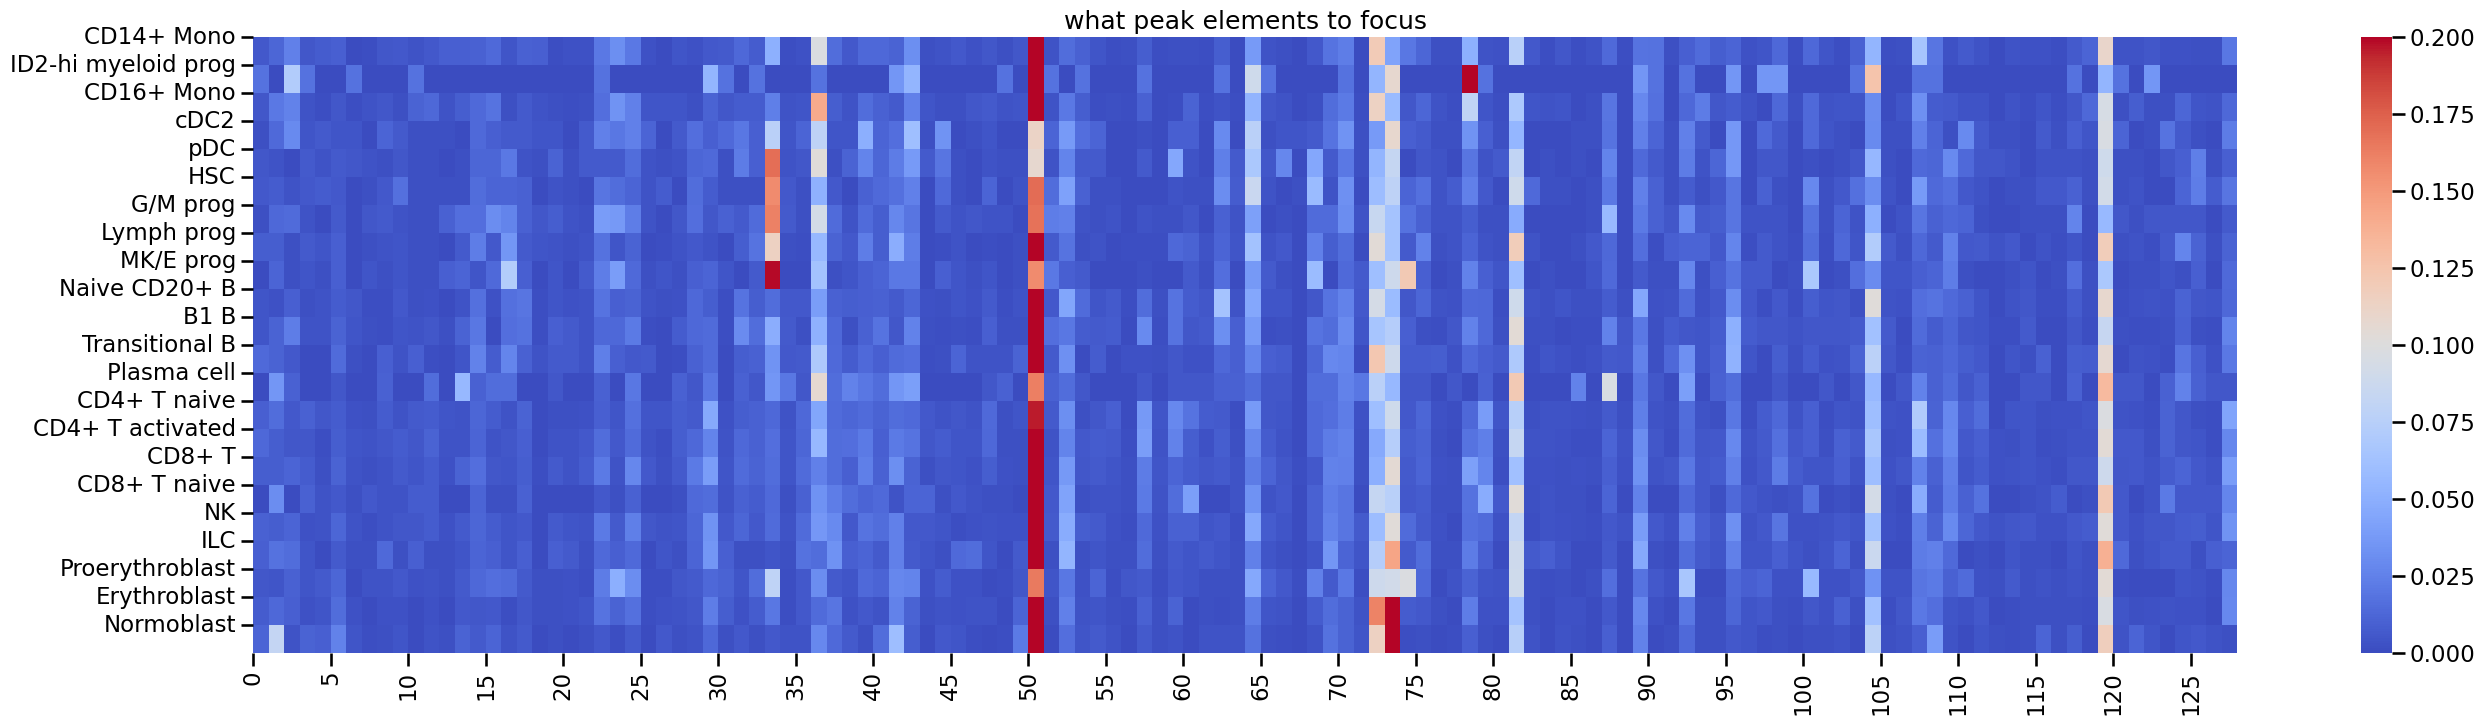

In [22]:
# which peak elements are most concerned by peak
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
key_col = np.zeros((len(att_layer2_atac),att_layer2_atac[0].shape[-1]))
for i in range(len(att_layer2_atac)):
    for j in range(att_layer2_atac[i].shape[0]):
        att_mean = att_layer2_atac[i][j].mean(0).detach().cpu()
        key_c = np.where(att_mean>0.35)[0]
        for c in key_c:
            key_col[i,c] += 1
    key_col[i] = key_col[i]/att_layer2_atac[i].shape[0]

plt.figure(figsize=(32,8))
sns.heatmap(key_col, cmap='coolwarm', vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,key_col.shape[1],5), labels=np.arange(0,key_col.shape[1],5))
plt.title('what peak elements to focus')

# gradient back propagation analysis

In [ ]:
# load genecode file
final_df = pd.read_csv('hg38/gencode_hg38.csv')

analysis denoising network gradient (use CD4+ T activated as example)

In [23]:
time_step = 1
interested_type = type_list[14] 
down_sample = 5
model_kwargs = {}
batch = {}

x1 = torch.tensor(rna[::down_sample].X.toarray(),requires_grad=True)
x2 = torch.tensor(atac[::down_sample].X.toarray(),requires_grad=True)
index = list(range(rna[::down_sample].shape[0])) if interested_type=='all' else (rna[::down_sample].obs['cell_type'] == interested_type)

batch["X_norm"] = {'rna':x1,'atac':x2}
z = encoder_model.encode(batch)
video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())

noise ={"video":torch.randn_like(video_start),\
    "audio":torch.randn_like(audio_start)}

t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])#.detach()
audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])#.detach()

video_t = video_t[index]
audio_t = audio_t[index]
t = t[index]
labels = model_kwargs["label"][index]

**note**: the returned att_vec has the following content<br>
att_vec[0]-att_vec[3] for first cross attention<br>
att_vec[0] - rna feature vector ; att_vec[1] - atac feature vector <br>
att_vec[2] - attention map of atac to rna (what peak to focus)<br>
att_vec[3] - attention map of rna to atac (what gene to focus)<br>
[4]-[7] for second cross attention, [8]-[11] for third cross attention

In [24]:
all_key_genes = [] 
all_key_peaks = [] 
all_position = []

for key_ele in np.unique(positions[1]):

    batch["X_norm"] = {'rna':x1,'atac':x2}
    z = encoder_model.encode(batch)
    video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
    audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
    model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())
    noise ={"video":torch.randn_like(video_start),\
        "audio":torch.randn_like(audio_start)}
    t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
    video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])
    audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])
    video_t = video_t[index]
    audio_t = audio_t[index]
    t = t[index]
    labels = model_kwargs["label"][index]

    noise_pred_video, noise_pred_audio, att_vec = multimodal_model(video_t,audio_t,t,labels,return_attvec=True)
    att_vec[4][:,:,key_ele].mean().backward(create_graph=True,)
    top_k = mdata['rna'].shape[1]
    values, indices = torch.topk(abs(x1.grad[index]).mean(0)*(x1[index].sum(0)>int(x1[index].shape[0]*0.2)), top_k)#

    top_gene = np.array([mdata['rna'].var_names[id] for id in np.array(indices)])
    all_key_genes += list(top_gene[:100])

    multimodal_model.zero_grad()
    encoder_model.zero_grad()
    x1.grad.zero_()
    x2.grad.zero_()

for key_ele in np.unique(positions[0]):

    batch["X_norm"] = {'rna':x1,'atac':x2}
    z = encoder_model.encode(batch)
    video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
    audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
    model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())
    noise ={"video":torch.randn_like(video_start),\
        "audio":torch.randn_like(audio_start)}
    t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
    video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])
    audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])
    video_t = video_t[index]
    audio_t = audio_t[index]
    t = t[index]
    labels = model_kwargs["label"][index]

    noise_pred_video, noise_pred_audio, att_vec = multimodal_model(video_t,audio_t,t,labels,return_attvec=True)
    att_vec[5][:,:,key_ele].mean().backward(create_graph=True)
    values2, indices2 = torch.topk(abs(x2.grad[index]).mean(0)*(x2[index].sum(0)>int(x2[index].shape[0]*0.05)), 36553)#
    top_peak = np.array([mdata['atac'].var_names[id] for id in np.array(indices2)])
    all_key_peaks += list(top_peak[:100])

    multimodal_model.zero_grad()
    encoder_model.zero_grad()
    x1.grad.zero_()
    x2.grad.zero_()

/home/lep/miniconda3/envs/scmuldiff/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1171.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [25]:
key_ele_gene = {}
key_ele_peak = {}
for i in range(np.unique(positions[1]).shape[0]):
    key_ele_gene[np.unique(positions[1])[i]]=all_key_genes[i*100:(i+1)*100]
for i in range(np.unique(positions[0]).shape[0]):
    key_ele_peak[np.unique(positions[0])[i]]=all_key_peaks[i*100:(i+1)*100]
# np.savez('hete_net_14.npz', elements=positions, key_gene=np.array([key_ele_gene], dtype=object), key_peak=np.array([key_ele_peak], dtype=object))

In [26]:
key_ele_gene.keys(),key_ele_peak.keys()

(dict_keys([11, 38, 47, 100, 126]), dict_keys([28, 45, 50, 57, 79, 81, 107]))

In [ ]:
# an example of the gene related to 47th gene element
for gene in key_ele_gene[47]:
    print(gene)

MAF
MAST4
LINC00299
FAAH2
AC139720.1
ADAM19
GZMK
PBXIP1
ARRDC3
RGS1
OST4
CD226
NOL4L
HBP1
AC022217.3
STK17A
LPXN
A2M
GALM
TAGAP
ZFYVE28
ETNK1
TRIR
UQCRB
MTRNR2L12
GNLY
ITGA6
NELL2
KLRB1
LEPROTL1
CD28
CD5
GPSM3
TNFSF8
AC013652.1
TGFBR3
TRAT1
CSGALNACT1
ZNF331
DNAJB1
EPHA4
DDX3X
MT-ND3
FRY
CFDP1
ZNF217
MYO1G
SFMBT1
SNRNP200
TSHZ2
EPSTI1
RNPC3
RNF166
RANBP2
DDX18
PTPRM
GATA3
NSRP1
CREM
UBL5
IFRD1
H1FX
CMSS1
GPR155
S100A8
DGKA
LRIG1
PCSK7
LBH
CD2AP
EIF4E3
LAT
GBP5
LPIN2
PRKCQ-AS1
IGF2R
TESPA1
TIAL1
GPR174
PCMTD1
TOB1
CAPN2
TRG-AS1
ATP5MG
RORA-AS1
WWP2
TRAF3IP3
FAM53B
GOLGA8A
LINC-PINT
FCMR
NLRC3
NOP58
GIMAP4
MAPRE2
KLRG1
COMMD6
CHD3
MT-ATP6
EIF3M


In [ ]:
# an example to fine the related peaks' corresponding (nearst) gene to 104th peak element
for peak in key_ele_peak[104]:
    print(find_nearest_gene(final_df, peak)[0][0])

GZMA
SMG6
GGA3
C4orf50
DPP4
ENSG00000309832
SCAMP2
SH3RF3
ENSG00000308252
ELAPOR2
COPS8-DT
STAM
ENSG00000301728
ENSG00000250602
ENSG00000309950
ITK
CCDC7
SLC7A6
LINC02646
ENSG00000298044
ENSG00000259704
ENSG00000285635
ITGB1-DT
DAB1
PRKCB
ENSG00000289377
RNA5SP431
TSPEAR
ZDHHC11B
CRACDL
MED15
ARHGAP15
ENSG00000299620
RN7SKP166
NLRC5
ENSG00000233538
RUNX2
NPM1P2
DSTN
NDFIP2-AS1
CXCR5
PVT1
RNF216
ADAM19
SNX9
ENSG00000300850
SUPT3H
ENSG00000291013
HDAC4
LRRC8C-DT
SPOCK2
ENSG00000299987
PRDM2
XYLT1
CFAP299
PECAM1
ARHGAP10
EMILIN2
CNNM2
LRRC8C
BEGAIN
LEF1
CDK5RAP1
EVI5
DGKZ
ENSG00000309104
FIRRM
EHD4
OXNAD1
ENSG00000288724
CORO1B
ARHGAP25
TIAM1
ADARB1
ENSG00000225649
BTF3L4P3
PRKCA
KCNJ1
USP12
SUSD4
ENSG00000308933
BEX5
ENSG00000306277
ITK
TRAF1
TRAF2
Y_RNA
ENSG00000288729
IKZF1
BPGM
LINC01991
ZBTB46
FYB1
NIBAN1
TMEM106B
ENSG00000300042
ETS1
EPAS1
GATA3
SLC25A26


In [116]:
for name in np.unique(all_key_genes):
    print(name)

A2M
AC013652.1
AC022217.3
AC079793.1
AC139720.1
AC245297.3
ADAM19
AGFG1
AL136456.1
ANKRD36
ANO6
ANTXR2
ANXA11
ANXA6
AP001011.1
APBA2
AQR
ARHGAP45
ARHGEF6
ARHGEF7
ARL4C
ARRDC3
ATF2
ATF7IP2
ATP10A
ATP5IF1
ATP5MG
BRD1
BRD7
BTBD11
C12orf57
CAPN2
CBFB
CCL5
CCND2
CCSER2
CD226
CD28
CD2AP
CD37
CD3D
CD3E
CD3G
CD48
CD5
CD81
CDC42SE1
CDK5RAP2
CDKN1B
CDV3
CFDP1
CHD3
CHURC1
CLIC1
CLIP1
CMSS1
CNOT1
COMMD6
COX6A1
COX6B1
CREM
CRIP1
CSGALNACT1
CYTOR
DAZAP2
DDX10
DDX18
DDX3X
DDX46
DENND4C
DGKA
DIPK1A
DNAJB1
DUSP16
EDF1
EIF3M
EIF4E3
EIF5B
ELP2
EPHA4
EPSTI1
ERAP2
ERP29
ETNK1
FAAH2
FAM53B
FARS2
FCMR
FLNA
FMN1
FRY
GADD45B
GALM
GATA3
GBP5
GIMAP4
GNLY
GOLGA8A
GOLGA8B
GPR155
GPR174
GPR183
GPSM3
GRAP2
GZMA
GZMK
H1FX
HBP1
HELB
HINT1
HIVEP1
HMGN1
IFRD1
IGF2R
IKZF2
IL10RA
IL2RG
ITGA6
IVNS1ABP
KAT2B
KLRB1
KLRG1
LAT
LBH
LDHB
LEF1
LEPROTL1
LINC-PINT
LINC00299
LINC00513
LINC00861
LINC01138
LINC02694
LPIN2
LPXN
LRIG1
LTB
MAF
MALT1
MAPRE2
MAST4
MCL1
MED23
MT-ATP6
MT-CO1
MT-CO2
MT-CYB
MT-ND1
MT-ND2
MT-ND3
MT-ND4
MT-ND5
M

In [56]:
for name in np.unique(all_key_peaks):
    print(name.replace('-', ':', 1))

chr1:100400124-100401025
chr1:100452357-100453271
chr1:100927083-100927969
chr1:101357133-101358041
chr1:108703358-108704087
chr1:116556331-116557223
chr1:116738599-116739461
chr1:116877748-116878647
chr1:117658424-117659293
chr1:13702529-13703436
chr1:151830384-151831295
chr1:154791005-154791840
chr1:156124729-156125582
chr1:160664488-160665308
chr1:167441913-167442794
chr1:169694194-169695012
chr1:181159372-181160283
chr1:184843493-184844395
chr1:18948169-18949079
chr1:19074232-19075107
chr1:193478979-193479887
chr1:194289309-194290212
chr1:19687950-19688899
chr1:198187853-198188770
chr1:198668796-198669696
chr1:203682362-203683265
chr1:206715677-206716563
chr1:206736878-206737712
chr1:206784197-206785074
chr1:206816648-206817552
chr1:221712956-221713713
chr1:223363861-223364743
chr1:226444671-226445586
chr1:227773894-227774801
chr1:229253318-229254119
chr1:232923711-232924616
chr1:234730807-234731559
chr1:234758605-234759500
chr1:25796521-25797356
chr1:38977438-38978360
chr1:3918354

# chrom-gene relation case study

again, take CD4+ T activated as an example

In [14]:
type_list

array(['CD14+ Mono', 'ID2-hi myeloid prog', 'CD16+ Mono', 'cDC2', 'pDC',
       'HSC', 'G/M prog', 'Lymph prog', 'MK/E prog', 'Naive CD20+ B',
       'B1 B', 'Transitional B', 'Plasma cell', 'CD4+ T naive',
       'CD4+ T activated', 'CD8+ T', 'CD8+ T naive', 'NK', 'ILC',
       'Proerythroblast', 'Erythroblast', 'Normoblast'], dtype='<U19')

In [32]:
type_index = [14]
bed_file = []

for n in type_index:
    if n in [13,14]:
        bed_file.append(pd.read_csv('encode/CD4.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))
    elif n in [1]:
        bed_file.append(pd.read_csv('encode/myeloid.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))
    elif n in [9,10,11]:
        bed_file.append(pd.read_csv('encode/B cell.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))
    elif n in [15,16]:
        bed_file.append(pd.read_csv('encode/CD8.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))
    elif n in [17]:
        bed_file.append(pd.read_csv('encode/NK.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))
    elif n in [0]:
        bed_file.append(pd.read_csv('encode/CD14.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))


calcualte the overlap number

In [34]:
all_overlaps = []
all_peaks = []
all_tss = []

num_genes = []
num_enhancers = []

for ii, k in enumerate(type_index):

    cross_map = att_layer2[k].mean(0).cpu().detach().numpy()+att_layer2_atac[k].mean(0).cpu().detach().numpy().T
    flattened_indices = np.argsort(cross_map, axis=None)[-15:]
    positions = np.unravel_index(flattened_indices, cross_map.shape)
    max_values = cross_map[positions]

    time_step = 1
    interested_type = type_list[k] 
    down_sample = 5
    model_kwargs = {}
    batch = {}

    x1 = torch.tensor(rna[::down_sample].X.toarray(),requires_grad=True)
    x2 = torch.tensor(atac[::down_sample].X.toarray(),requires_grad=True)
    index = list(range(rna[::down_sample].shape[0])) if interested_type=='all' else (rna[::down_sample].obs['cell_type'] == interested_type)


    all_key_genes = [] 
    all_key_peaks = [] 
    all_position = []

    for key_ele in np.unique(positions[1][-15:]):

        batch["X_norm"] = {'rna':x1,'atac':x2}
        z = encoder_model.encode(batch)
        video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
        audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
        model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())
        noise ={"video":torch.randn_like(video_start),\
            "audio":torch.randn_like(audio_start)}
        t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
        video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])
        audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])
        video_t = video_t[index]
        audio_t = audio_t[index]
        t = t[index]
        labels = model_kwargs["label"][index]

        noise_pred_video, noise_pred_audio, att_vec = multimodal_model(video_t,audio_t,t,labels,return_attvec=True)
        att_vec[4][:,:,key_ele].mean().backward(create_graph=True,)
        top_k = mdata['rna'].shape[1]
        values, indices = torch.topk(abs(x1.grad[index]).mean(0)*(x1[index].sum(0)>int(x1[index].shape[0]*0.2)), top_k)#
        top_gene = np.array([mdata['rna'].var_names[id] for id in np.array(indices)])
        all_key_genes += list(top_gene[:100])

        multimodal_model.zero_grad()
        encoder_model.zero_grad()
        x1.grad.zero_()
        x2.grad.zero_()

    for key_ele in np.unique(positions[0][-15:]):

        batch["X_norm"] = {'rna':x1,'atac':x2}
        z = encoder_model.encode(batch)
        video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
        audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
        model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())
        noise ={"video":torch.randn_like(video_start),\
            "audio":torch.randn_like(audio_start)}
        t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
        video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])
        audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])
        video_t = video_t[index]
        audio_t = audio_t[index]
        t = t[index]
        labels = model_kwargs["label"][index]

        noise_pred_video, noise_pred_audio, att_vec = multimodal_model(video_t,audio_t,t,labels,return_attvec=True)
        att_vec[5][:,:,key_ele].mean().backward(create_graph=True)
        values2, indices2 = torch.topk(abs(x2.grad[index]).mean(0)*(x2[index].sum(0)>int(x2[index].shape[0]*0.1)), mdata['atac'].shape[1])#
        top_peak = np.array([mdata['atac'].var_names[id] for id in np.array(indices2)])
        
        all_key_peaks += list(top_peak[:200])

        multimodal_model.zero_grad()
        encoder_model.zero_grad()
        x1.grad.zero_()
        x2.grad.zero_()

    chromosome_segments = np.unique(all_key_peaks)
    final_df['seqname'] = [name.split('_')[0] for name in final_df['seqname']]
    
    enhancers = []
    for segment in chromosome_segments:
        overlaps = find_enhancer_overlaps(bed_file[ii], segment)
        if not overlaps.empty:
            for i in range(overlaps.shape[0]):
                enhancers.append('-'.join([overlaps['chrom'].values[i],str(overlaps['start'].values[i]),str(overlaps['end'].values[i])]))
    overlap_gene = []
    overlap_seg = []
    # 查找每个染色体片段的最近基因
    for segment in chromosome_segments:
        gene_name, feature = find_nearest_gene(segment)
        if gene_name is not None:
            overlap_gene+=gene_name
            overlap_seg.append(segment)
    
    results = []
    for segment in chromosome_segments:
        result = check_tss_overlap(final_df, segment)
        if len(result)>0:
            results.append(result)
    
    all_tss.append(np.unique(np.concatenate(results)[np.in1d(np.concatenate(results),np.unique(all_key_genes))]))
    all_overlaps.append(np.array(overlap_gene)[np.in1d(overlap_gene,np.unique(all_key_genes))])
    all_peaks.append(np.array(chromosome_segments))
    num_genes.append(np.unique(all_key_genes).shape[0])
    num_enhancers.append(len(enhancers))
    num_overlap = np.array(overlap_gene)[np.in1d(overlap_gene,np.unique(all_key_genes))].shape[0]
    num_tts = np.unique(np.concatenate(results)[np.in1d(np.concatenate(results),np.unique(all_key_genes))]).shape[0]
    print(f'{type_list[k]}: {np.unique(all_key_genes).shape[0]} genes, {chromosome_segments.shape[0]} peaks, {len(enhancers)} enhancer, {num_overlap} overlap, {num_tts} tts,' )


CD4+ T activated: 291 genes, 537 peaks, 545 enhancer, 31 overlap, 6 tts,


obtain the overlaped gene and chrom

In [36]:
# def parse_segment(segment):
#     """解析染色质片段，返回染色体、起始位置和结束位置"""
#     chrom, positions = segment.split('-')[0], '-'.join(segment.split('-')[1:])
#     start_pos, end_pos = map(int, positions.split('-'))
#     return chrom, start_pos, end_pos

def check_overlap(segment1, segment2):
    """检查两个片段是否重叠"""
    chrom1, start1, end1 = parse_segment(segment1)
    chrom2, start2, end2 = parse_segment(segment2)

    # 判断两个片段是否在同一个染色体上并且重叠
    return chrom1 == chrom2 and start1 <= end2 and end1 >= start2

def find_overlapping_segments(list1, list2):
    """查找两个片段列表中的重叠片段"""
    overlapping = []
    for seg1 in list1:
        for seg2 in list2:
            if check_overlap(seg1, seg2):
                overlapping.append(seg1)
    return overlapping

type_index_loop = [14]
bed_file_loop = []
for n in type_index_loop:
    if n in [13,14,15,16]:
        bed_file_loop.append(pd.read_csv('hichip/loop_info_T_cell_hichipper.csv',))
    elif n in [9,10,11]:
        bed_file_loop.append(pd.read_csv('hichip/loop_info_B_cell_hichipper.csv',))

for iid, item in enumerate([0]):  # 在type_index中的位置
    print(type_list[type_index_loop[iid]])
    print('all overlap: ',all_overlaps[item])
    print('tss: ')
    for tss in all_tss[item]:
        print(tss)
        chrom = final_df[(final_df['gene_name']==tss) & (final_df['feature']=='gene')][['seqname','start','end']].values[0][0]
        start_id = str(final_df[(final_df['gene_name']==tss) & (final_df['feature']=='gene')][['seqname','start','end']].values[0][1])[:2]
        
        gene_seg = final_df[(final_df['gene_name']==tss) & (final_df['feature']=='gene')][['seqname','start','end','strand']].values[0]
        if gene_seg[-1] == '+':
            tss_seg = '-'.join([gene_seg[0],str(gene_seg[1]-3000),str(gene_seg[1])])
        else:
            tss_seg = '-'.join([gene_seg[0],str(gene_seg[2]),str(gene_seg[2]+3000)])
        print(tss_seg)
        overlaps = find_enhancer_overlaps_loop(bed_file_loop[iid], tss_seg)
        if overlaps.empty:
            continue

        enhancers = []
        for kkk in range(overlaps.shape[0]):
            enhancers.append('-'.join([overlaps['chrom'].values[kkk],str(int(overlaps['start'].values[kkk])),str(int(overlaps['end'].values[kkk]))]))
            enhancers.append('-'.join([overlaps['chrom'].values[kkk],str(int(overlaps['start2'].values[kkk])),str(int(overlaps['end2'].values[kkk]))]))
        
        selected_peak = [it for it in all_peaks[item] if it.startswith(chrom+'-'+start_id)]

        overlaps_enhancer = find_overlapping_segments(selected_peak, enhancers)
        print('overlaps_enhancer: ',np.unique(overlaps_enhancer))

CD4+ T activated
all overlap:  ['SELL' 'TRAF3IP3' 'TGFBR3' 'TGFBR3' 'GATA3' 'CD3D' 'CD5' 'DUSP16'
 'DUSP16' 'TESPA1' 'KLRG1' 'FMN1' 'USP36' 'LPIN2' 'MALT1' 'CD28' 'EPHA4'
 'GALM' 'NOL4L' 'SFMBT1' 'TCF7' 'RETREG1' 'PRDM1' 'SCML4' 'LINC-PINT'
 'LINC00513' 'STK17A' 'CSGALNACT1' 'CSGALNACT1' 'TNFSF8' 'P2RY8']
tss: 
CD28
chr2-203703517-203706517
overlaps_enhancer:  ['chr2-203706134-203707025']
CD5
chr11-61099489-61102489
overlaps_enhancer:  ['chr11-61021436-61022320' 'chr11-61041942-61042854'
 'chr11-61101933-61102835']
DIPK1A
chr1-92961522-92964522
overlaps_enhancer:  ['chr1-92962295-92963080']
FMN1
chr15-33194714-33197714
overlaps_enhancer:  []
RETREG1
chr5-16617101-16620101
overlaps_enhancer:  ['chr5-16616577-16617478']
TESPA1
chr12-54984762-54987762
overlaps_enhancer:  ['chr12-54984440-54985280']
